In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/NPY_Files"
!ls "/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1"


'1. Indoor'  '2. Outdoor'  '3. Indoor_dark'
pc_10.npy  pc_13.npy  pc_16.npy  pc_19.npy  pc_2.npy  pc_5.npy	pc_8.npy
pc_11.npy  pc_14.npy  pc_17.npy  pc_1.npy   pc_3.npy  pc_6.npy	pc_9.npy
pc_12.npy  pc_15.npy  pc_18.npy  pc_20.npy  pc_4.npy  pc_7.npy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class LiDARFaceDataset(Dataset):
    def __init__(self, data_paths, labels, transform=None):
        self.data_paths = data_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        npy_file = np.load(self.data_paths[idx])  # Load .npy file
        tensor_data = torch.tensor(npy_file, dtype=torch.float32)  # Convert to tensor
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Convert label to tensor

        if self.transform:
            tensor_data = self.transform(tensor_data)

        return tensor_data, label

# Function to load dataset
def load_dataset(root_dir):
    categories = {'real_cloud_data': 0, 'mask_cloud_data': 1, 'paper_cloud_data': 2, 'replay_cloud_data': 3}
    data_paths = []
    labels = []

    # Iterate through folders
    for env in ['1. Indoor', '2. Outdoor', '3. Indoor_dark']:
        env_path = os.path.join(root_dir, env)
        for attack_type, label in categories.items():
            attack_path = os.path.join(env_path, attack_type)
            for subject_folder in map(str, range(1, 13)):  # 1-12
                subject_path = os.path.join(attack_path, subject_folder)

                # Use glob to fetch files
                npy_files = glob.glob(os.path.join(subject_path, "*.npy"))

                if not npy_files:
                    print(f"Warning: No .npy files found in {subject_path}")
                    continue

                data_paths.extend(npy_files)
                labels.extend([label] * len(npy_files))

    return train_test_split(data_paths, labels, test_size=0.2, random_state=42)

class CloudNet(nn.Module):
    def __init__(self):
        super(CloudNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 4)  # 4 classes
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example usage
root_dir = "/content/drive/MyDrive/NPY_Files"
data_train, data_test, labels_train, labels_test = load_dataset(root_dir)

# Create DataLoaders
train_dataset = LiDARFaceDataset(data_train, labels_train)
test_dataset = LiDARFaceDataset(data_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = CloudNet()
print(f"Model initialized: {model}")

print(f"Loaded {len(train_dataset)} training samples and {len(test_dataset)} test samples.")

Model initialized: CloudNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Loaded 2310 training samples and 578 test samples.


In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class LiDARFaceDataset(Dataset):
    def __init__(self, data_paths, labels, transform=None):
        self.data_paths = data_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        npy_file = np.load(self.data_paths[idx])  # Load .npy file
        tensor_data = torch.tensor(npy_file, dtype=torch.float32)  # Convert to tensor

        # Ensure correct shape (1, H, W) for CNN input
        if len(tensor_data.shape) == 3:  # If (C, H, W), convert to (1, H, W)
            tensor_data = tensor_data.mean(dim=0, keepdim=True)  # Convert to grayscale
        elif len(tensor_data.shape) == 2:  # If (H, W), add channel dim
            tensor_data = tensor_data.unsqueeze(0)

        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Convert label to tensor

        if self.transform:
            tensor_data = self.transform(tensor_data)

        return tensor_data, label

# Function to load dataset
def load_dataset(root_dir):
    categories = {'real_cloud_data': 0, 'mask_cloud_data': 1, 'paper_cloud_data': 2, 'replay_cloud_data': 3}
    data_paths = []
    labels = []

    # Iterate through folders
    for env in ['1. Indoor', '2. Outdoor', '3. Indoor_dark']:
        env_path = os.path.join(root_dir, env)
        for attack_type, label in categories.items():
            attack_path = os.path.join(env_path, attack_type)
            for subject_folder in map(str, range(1, 13)):  # 1-12
                subject_path = os.path.join(attack_path, subject_folder)

                # Use glob to fetch files
                npy_files = glob.glob(os.path.join(subject_path, "*.npy"))

                if not npy_files:
                    print(f"Warning: No .npy files found in {subject_path}")
                    continue

                data_paths.extend(npy_files)
                labels.extend([label] * len(npy_files))

    return train_test_split(data_paths, labels, test_size=0.2, random_state=42)

class CloudNet(nn.Module):
    def __init__(self, input_shape=(1, 256, 4)):
        super(CloudNet, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d((2, 1))  # Adjusted pooling to avoid shrinking width to zero

        # Compute feature map size dynamically
        with torch.no_grad():
            sample_input = torch.zeros(1, *input_shape)
            sample_output = self._get_conv_output(sample_input)
        self.fc1 = nn.Linear(sample_output, 256)
        self.fc2 = nn.Linear(256, 4)  # 4 classes

    def _get_conv_output(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        return x.numel()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example usage
root_dir = "/content/drive/MyDrive/NPY_Files"
data_train, data_test, labels_train, labels_test = load_dataset(root_dir)

# Create DataLoaders
train_dataset = LiDARFaceDataset(data_train, labels_train)
test_dataset = LiDARFaceDataset(data_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = CloudNet()
print(f"Model initialized: {model}")

print(f"Loaded {len(train_dataset)} training samples and {len(test_dataset)} test samples.")

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Debugging input shape
        print(f"Input shape before model: {inputs.shape}")

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

Model initialized: CloudNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)
Loaded 2310 training samples and 578 test samples.
Input shape before model: torch.Size([16, 1, 256, 4])
Input shape before model: torch.Size([16, 1, 256, 4])
Input shape before model: torch.Size([16, 1, 256, 4])
Input shape before model: torch.Size([16, 1, 256, 4])
Input shape before model: torch.Size([16, 1, 256, 4])
Input shape before model: torch.Size([16, 1, 256, 4])
Input shape before model: torch.Size([16, 1, 256, 4])
Input shape before model: torch.Size([16, 1, 256, 4])
Input shape before 

Accuracy: 0.8858
Classification Report:
              precision    recall  f1-score   support

        real       0.77      0.72      0.75       134
        mask       0.77      0.81      0.79       155
       paper       1.00      1.00      1.00       138
      replay       1.00      1.00      1.00       151

    accuracy                           0.89       578
   macro avg       0.89      0.88      0.88       578
weighted avg       0.89      0.89      0.89       578



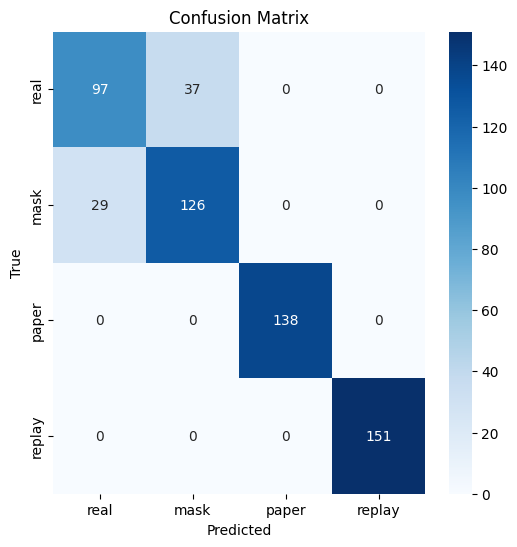

In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class LiDARFaceDataset(Dataset):
    def __init__(self, data_paths, labels, transform=None):
        self.data_paths = data_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        npy_file = np.load(self.data_paths[idx])
        tensor_data = torch.tensor(npy_file, dtype=torch.float32)

        if len(tensor_data.shape) == 3:
            tensor_data = tensor_data.mean(dim=0, keepdim=True)
        elif len(tensor_data.shape) == 2:
            tensor_data = tensor_data.unsqueeze(0)

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            tensor_data = self.transform(tensor_data)

        return tensor_data, label

# Evaluation Function
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {acc:.4f}')
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['real', 'mask', 'paper', 'replay']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'mask', 'paper', 'replay'], yticklabels=['real', 'mask', 'paper', 'replay'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Run Evaluation
evaluate_model(model, test_loader, device)


Accuracy: 0.8858
Classification Report:
              precision    recall  f1-score   support

        real       0.77      0.72      0.75       134
        mask       0.77      0.81      0.79       155
       paper       1.00      1.00      1.00       138
      replay       1.00      1.00      1.00       151

    accuracy                           0.89       578
   macro avg       0.89      0.88      0.88       578
weighted avg       0.89      0.89      0.89       578



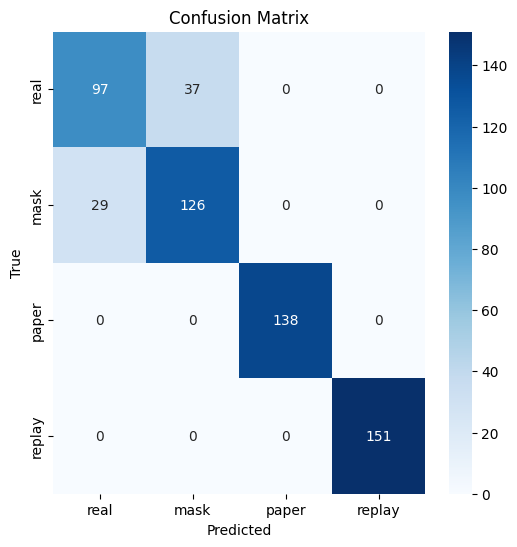

In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class LiDARFaceDataset(Dataset):
    def __init__(self, data_paths, labels, transform=None):
        self.data_paths = data_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        npy_file = np.load(self.data_paths[idx])
        tensor_data = torch.tensor(npy_file, dtype=torch.float32)

        if len(tensor_data.shape) == 3:
            tensor_data = tensor_data.mean(dim=0, keepdim=True)
        elif len(tensor_data.shape) == 2:
            tensor_data = tensor_data.unsqueeze(0)

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            tensor_data = self.transform(tensor_data)

        return tensor_data, label

# Evaluation Function
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {acc:.4f}')
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['real', 'mask', 'paper', 'replay']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'mask', 'paper', 'replay'], yticklabels=['real', 'mask', 'paper', 'replay'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Run Evaluation
evaluate_model(model, test_loader, device)


Accuracy: 0.8858
Precision: 0.8858
Recall: 0.8858
F1 Score: 0.8855
ROC AUC Score: 0.9754
Classification Report:
              precision    recall  f1-score   support

        real       0.77      0.72      0.75       134
        mask       0.77      0.81      0.79       155
       paper       1.00      1.00      1.00       138
      replay       1.00      1.00      1.00       151

    accuracy                           0.89       578
   macro avg       0.89      0.88      0.88       578
weighted avg       0.89      0.89      0.89       578



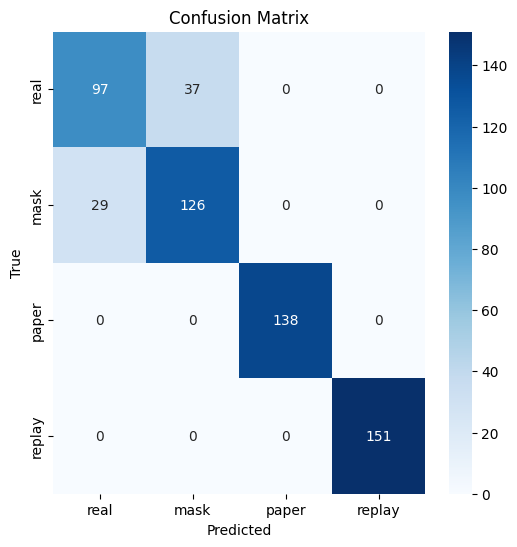

Sample 550: Predicted Class: paper (Confidence: 1.0000)
Sample 349: Predicted Class: replay (Confidence: 1.0000)
Sample 52: Predicted Class: paper (Confidence: 1.0000)
Sample 408: Predicted Class: replay (Confidence: 1.0000)
Sample 566: Predicted Class: paper (Confidence: 1.0000)


In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import random

class LiDARFaceDataset(Dataset):
    def __init__(self, data_paths, labels, transform=None):
        self.data_paths = data_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        npy_file = np.load(self.data_paths[idx])
        tensor_data = torch.tensor(npy_file, dtype=torch.float32)

        if len(tensor_data.shape) == 3:
            tensor_data = tensor_data.mean(dim=0, keepdim=True)
        elif len(tensor_data.shape) == 2:
            tensor_data = tensor_data.unsqueeze(0)

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            tensor_data = self.transform(tensor_data)

        return tensor_data, label

# Evaluation Function
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_probs, multi_class='ovr')

    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['real', 'mask', 'paper', 'replay']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'mask', 'paper', 'replay'], yticklabels=['real', 'mask', 'paper', 'replay'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Run Evaluation
evaluate_model(model, test_loader, device)

# Sample Predictions
def predict_random_samples(model, test_dataset, device, num_samples=5):
    model.eval()
    sample_indices = random.sample(range(len(test_dataset)), num_samples)
    classes = ['real', 'mask', 'paper', 'replay']

    for idx in sample_indices:
        sample_input, _ = test_dataset[idx]
        sample_input = sample_input.unsqueeze(0).to(device)  # Add batch dimension
        with torch.no_grad():
            output = model(sample_input)
            probs = F.softmax(output, dim=1)
            predicted_class = torch.argmax(probs, dim=1).item()

        print(f"Sample {idx}: Predicted Class: {classes[predicted_class]} (Confidence: {probs.max().item():.4f})")

# Predict random samples
predict_random_samples(model, test_dataset, device)


Model saved as cloudnet_model.h5
Model loaded from cloudnet_model.h5


<ipython-input-21-ffdb1943c6b8>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


Accuracy: 0.8858
Precision: 0.8858
Recall: 0.8858
F1 Score: 0.8855
Classification Report:
              precision    recall  f1-score   support

        real       0.77      0.72      0.75       134
        mask       0.77      0.81      0.79       155
       paper       1.00      1.00      1.00       138
      replay       1.00      1.00      1.00       151

    accuracy                           0.89       578
   macro avg       0.89      0.88      0.88       578
weighted avg       0.89      0.89      0.89       578



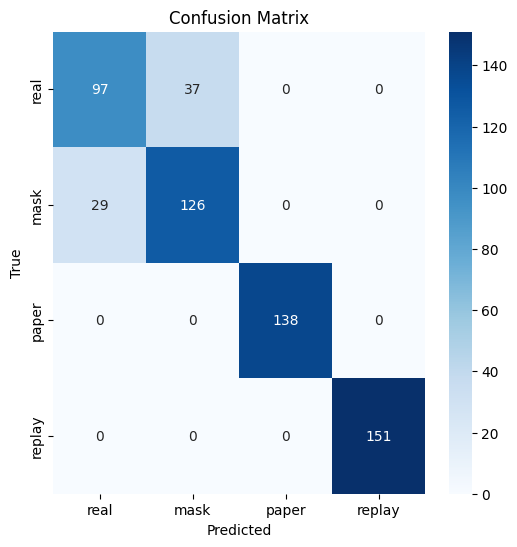

<ipython-input-21-ffdb1943c6b8>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='viridis')


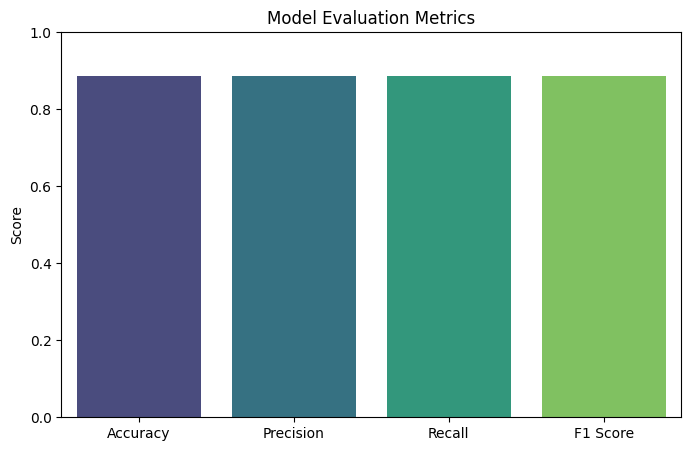

Actual Label  | Predicted Label
--------------------------------
mask         | mask
mask         | mask
mask         | mask
real         | real
replay       | replay
mask         | mask
real         | real
replay       | replay
real         | real
mask         | mask


In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Save the model
def save_model(model, filename="cloudnet_model.h5"):
    torch.save(model.state_dict(), filename)
    print(f"Model saved as {filename}")

# Load the model
def load_model(model, filename="cloudnet_model.h5"):
    model.load_state_dict(torch.load(filename))
    model.eval()
    print(f"Model loaded from {filename}")

# Function to evaluate model and generate metrics
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['real', 'mask', 'paper', 'replay']))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'mask', 'paper', 'replay'], yticklabels=['real', 'mask', 'paper', 'replay'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Visualization of Accuracy, Precision, Recall, F1 Score
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    scores = [acc, precision, recall, f1]

    plt.figure(figsize=(8,5))
    sns.barplot(x=metrics, y=scores, palette='viridis')
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Model Evaluation Metrics")
    plt.show()

# Function to test model and print predictions
def test_and_print_predictions(model, test_dataset, device, num_samples=10):
    model.eval()
    classes = ['real', 'mask', 'paper', 'replay']

    print("Actual Label  | Predicted Label")
    print("--------------------------------")

    for i in range(num_samples):
        sample_input, actual_label = test_dataset[i]
        sample_input = sample_input.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(sample_input)
            predicted_class = torch.argmax(output, dim=1).item()

        print(f"{classes[actual_label]:<12} | {classes[predicted_class]}")

# Save the trained model
save_model(model, "cloudnet_model.h5")

# Load the saved model for testing
load_model(model, "cloudnet_model.h5")

# Run evaluation
evaluate_model(model, test_loader, device)

# Run test predictions
test_and_print_predictions(model, test_dataset, device, num_samples=10)


In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Save the model
def save_model(model, filename="cloudnet_model.h5"):
    torch.save(model.state_dict(), filename)
    print(f"Model saved as {filename}")

# Load the model
def load_model(model, filename="cloudnet_model.h5"):
    model.load_state_dict(torch.load(filename))
    model.eval()
    print(f"Model loaded from {filename}")

# Function to evaluate model and generate metrics
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['real', 'mask', 'paper', 'replay']))

'''
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'mask', 'paper', 'replay'], yticklabels=['real', 'mask', 'paper', 'replay'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Separate Graphs for Accuracy, Precision, Recall, F1 Score
    epochs = list(range(1, len(y_true) + 1))

    plt.figure(figsize=(10,6))
    plt.plot(epochs, [acc] * len(epochs), label='Accuracy', color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(epochs, [precision] * len(epochs), label='Precision', color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.title("Precision Over Epochs")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(epochs, [recall] * len(epochs), label='Recall', color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.title("Recall Over Epochs")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(epochs, [f1] * len(epochs), label='F1 Score', color='purple')
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Over Epochs")
    plt.legend()
    plt.show()'''

# Function to test model and print predictions
def test_and_print_predictions(model, test_dataset, device, num_samples=10):
    model.eval()
    classes = ['real', 'mask', 'paper', 'replay']

    print("Actual Label  | Predicted Label")
    print("--------------------------------")

    for i in range(num_samples):
        sample_input, actual_label = test_dataset[i]
        sample_input = sample_input.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(sample_input)
            predicted_class = torch.argmax(output, dim=1).item()

        print(f"{classes[actual_label]:<12} | {classes[predicted_class]}")

# Save the trained model
save_model(model, "cloudnet_model.h5")

# Load the saved model for testing
load_model(model, "cloudnet_model.h5")

# Run evaluation
evaluate_model(model, test_loader, device)

# Run test predictions
test_and_print_predictions(model, test_dataset, device, num_samples=10)


Model saved as cloudnet_model.h5
Model loaded from cloudnet_model.h5


<ipython-input-26-65e0262723df>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


Accuracy: 0.8858
Precision: 0.8858
Recall: 0.8858
F1 Score: 0.8855
Classification Report:
              precision    recall  f1-score   support

        real       0.77      0.72      0.75       134
        mask       0.77      0.81      0.79       155
       paper       1.00      1.00      1.00       138
      replay       1.00      1.00      1.00       151

    accuracy                           0.89       578
   macro avg       0.89      0.88      0.88       578
weighted avg       0.89      0.89      0.89       578

Actual Label  | Predicted Label
--------------------------------
mask         | mask
mask         | mask
mask         | mask
real         | real
replay       | replay
mask         | mask
real         | real
replay       | replay
real         | real
mask         | mask


In [ ]:
import glob

files = glob.glob("/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/*.npy")
print("✅ Found files:", files)


✅ Found files: ['/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_5.npy', '/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_8.npy', '/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_15.npy', '/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_10.npy', '/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_6.npy', '/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_19.npy', '/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_4.npy', '/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_13.npy', '/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_9.npy', '/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_3.npy', '/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_17.npy', '/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_16.npy', '/content/drive/MyDrive/NPY_Files/1. Indoor/mask_cloud_data/1/pc_14.npy', '/content/drive/MyDrive/NPY_